Check effect of Negative Voja learning rule on MEG response

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes, numpy_bytes_to_str, norm_spa_vecs
from nengo_learn_assoc_mem.learning_rules.neg_voja import NegVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Setup

In [2]:
with h5py.File("../data/neg_voja_enc.h5", "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [3]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [4]:
save_file_name = "high_thresh_notebook"

In [5]:
t_pause = 0.1
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [6]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [7]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

## Selectively weaken inhibition for targets

So the foils don't have such a big MEG response

### Train recurrent connections

In [8]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [9]:
n_repeats = 2
sample_freq = 10

base_inhib = -2e-3
bcm_thresh = 50
bcm_lr = 1e-6

In [10]:
rec_inhib = base_inhib*(np.ones(n_neurons) - np.eye(n_neurons))

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network() as model:
    in_nd = nengo.Node(feed.feed)
    paused = nengo.Node(lambda t: 1-feed.paused)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)
    rec_learn = rec_bcm.RecBCM(n_neurons, rec_inhib, learning_rate=bcm_lr, threshold=bcm_thresh, max_inhib=-0.05, sample_every=t_each/sample_freq)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, rec_learn.in_neurons, synapse=0.01)
    nengo.Connection(ens.neurons, rec_learn.out_neurons, synapse=0.01)
    nengo.Connection(paused, rec_learn.enable, synapse=None)
    nengo.Connection(rec_learn.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:50.                                                 


## Save the results

In [11]:
lowpass = nengo.Lowpass(0.1)
nrn_rates = lowpass.filt(sim.data[p_spikes])
w_hist = np.array(rec_learn.weight_history)

In [12]:
with h5py.File(f"../data/neg_voja_rec_learn/{save_file_name}.h5", "w") as sv_fi:
    sv_fi.create_dataset("train_input", data=np.array(sim.data[p_in]))

    sv_fi.create_dataset("train_spikes", data=np.array(sim.data[p_spikes]))

    bcm = sv_fi.create_dataset("w_hist", data=w_hist)

    bcm.attrs["repeats"] = n_repeats
    bcm.attrs["sample_freq"] = sample_freq

    bcm.attrs["t_pause"] = t_pause
    bcm.attrs["t_present"] = t_present
    
    bcm.attrs["base_inhib"] = base_inhib
    bcm.attrs["thresh"] = bcm_thresh
    bcm.attrs["learning_rate"] = bcm_lr

## Sanity check

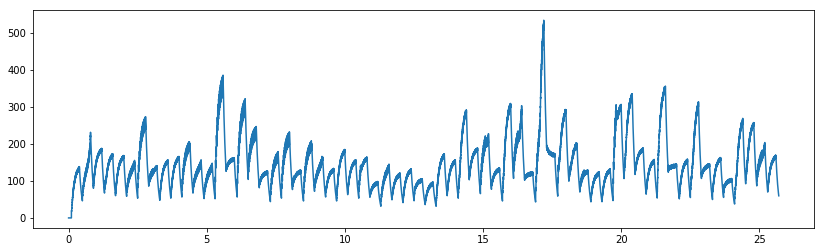

In [13]:
plt.figure(figsize=(14, 4))
plt.plot(sim.trange(), np.sum(nrn_rates, axis=1))

### Weight analysis

In [62]:
w_trange = sim.trange(dt=t_each/sample_freq)

In [46]:
w_hist.shape

(323, 500, 500)

In [47]:
triu_i  = np.triu_indices(w_hist.shape[1], k=1)
tril_i = np.tril_indices(w_hist.shape[1], k=-1)
wh_arr = np.concatenate((w_hist[:,  triu_i[0], triu_i[1]], w_hist[:, tril_i[0], tril_i[1]]), axis=1)

In [48]:
wh_arr.shape

(323, 249500)

In [49]:
wh_diff = np.diff(wh_arr, axis=0)
print(wh_diff.shape)
print(wh_diff.shape[0] * wh_diff.shape[1])

(322, 249500)
80339000


In [50]:
decr = wh_arr[-1][wh_arr[-1] < base_inhib].shape[0]
print(f"Number of weights decreased beyond base {base_inhib} by end: {decr}")
incr = wh_arr[-1][wh_arr[-1] > base_inhib].shape[0]
print(f"Number of weights increased beyond base {base_inhib} by end: {incr}")
print("Total changed", decr+incr)

Number of weights decreased beyond base -0.002 by end: 1963
Number of weights increased beyond base -0.002 by end: 138
Total changed 2101


In [51]:
incr_lines = wh_arr[:, wh_arr[-1] > base_inhib]
decr_lines = wh_arr[:, wh_arr[-1] < base_inhib]

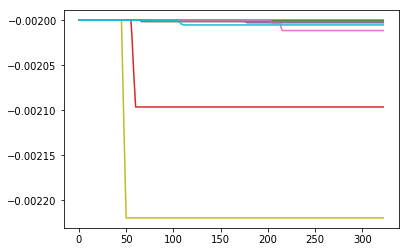

In [52]:
plt.plot(decr_lines[:, :10])

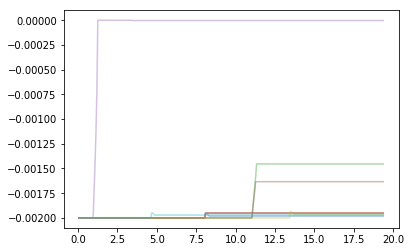

In [66]:
plt.plot(w_trange[:-2], incr_lines[:, :10], alpha=0.4);

In [55]:
thresh = -1e-3

min_w = wh_arr[-1][wh_arr[-1] < thresh].shape[0]
print(f"Number of weights decreased beyond {thresh}: {min_w}" )

Number of weights decreased beyond -0.001: 249496


In [56]:
print("Weights that actually changed")
wh_diff.shape[0] * wh_diff.shape[1] - wh_diff[wh_diff == 0].shape[0]

Weights that actually changed


7247

In [57]:
wobble = np.sum(np.abs(wh_diff), axis=0)

In [58]:
wob_idx = np.argsort(wobble)

In [59]:
min_wob = wh_diff[:, wob_idx[:10]]
max_wob = wh_diff[:, wob_idx[-10:]]

In [60]:
wobble[wobble <= 0.0001].shape

(249343,)

ValueError: x and y must have same first dimension, but have shapes (649,) and (322, 10)

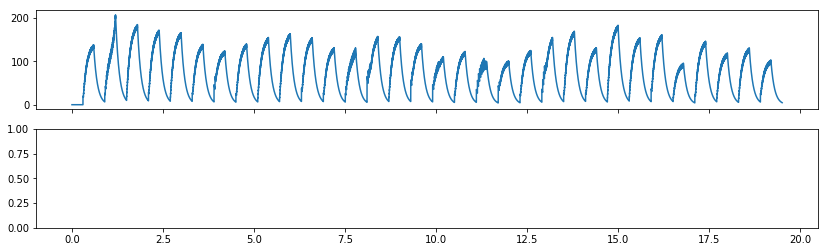

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 4))
ax1.plot(sim.trange(), np.sum(nrn_rates, axis=1))
ax2.plot(w_trange[:-1], max_wob);

### Evaluate recurrent connections on foils

In [14]:
rec_w = w_hist[-1]

In [15]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [16]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network() as learned_model:
    in_nd = nengo.Node(feed.feed)
    
    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_w, synapse=0.01)
    
    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


In [17]:
with h5py.File(f"../data/neg_voja_rec_learn/{save_file_name}.h5", "a") as sv_fi:
    sv_fi.create_dataset("spike_response", data=np.array(learned_sim.data[p_spikes]))

In [18]:
learned_meg = meg_from_spikes(learned_sim.data[p_spikes])

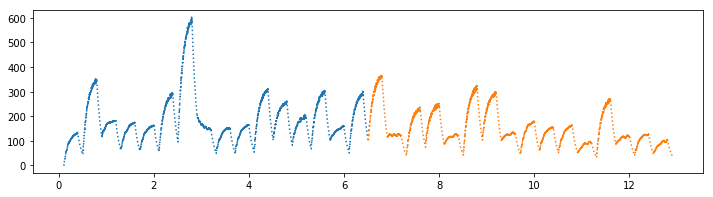

In [19]:
plt.figure(figsize=(12, 3))
plt.plot(learned_sim.trange()[fan1_slc], learned_meg[fan1_slc], linestyle=":")
plt.plot(learned_sim.trange()[fan2_slc], learned_meg[fan2_slc], linestyle=":")

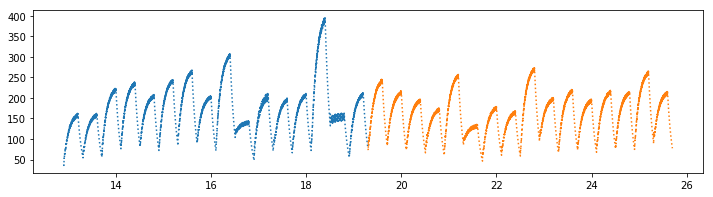

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(learned_sim.trange()[foil1_slc], learned_meg[foil1_slc], linestyle=":")
plt.plot(learned_sim.trange()[foil2_slc], learned_meg[foil2_slc], linestyle=":")

In [21]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = learned_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

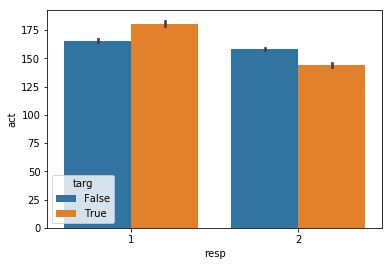

In [22]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)